In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import os

# create a cosine wave data
N = 100
x = np.linspace(0, 4 * np.pi, N)
y = np.cos(x)

# Prepare data for training
lookback = 10  # look back steps
x_data = np.array([y[i:i+lookback] for i in range(len(y)-lookback-1)])
y_data = y[lookback+1:]

# Split the data
x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.2, shuffle=False)

x_train = torch.tensor(x_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(-1)
x_val = torch.tensor(x_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32).unsqueeze(-1)

In [2]:
# Create Batches with DataLoaders
batch_size = 32
train_dataset = TensorDataset(x_train, y_train)
val_dataset = TensorDataset(x_val, y_val)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [3]:
# MLP model
class MLP(nn.Module):
    def __init__(self, input_size, output_size):
        super(MLP, self).__init__()
        self.input_size = input_size
        self.output_size = output_size

        self.layers = nn.Sequential(
            nn.Linear(lookback, 100),
            nn.ReLU(),
            nn.Linear(100, 50),
            nn.ReLU(),
            nn.Linear(50, 1)
        )

    def forward(self, x):
        output = self.layers(x)
        return output

In [4]:
# training function
def train(model, dataloader, criterion, optimizer):
    model.train()
    total_loss = 0.0
    for inputs, targets in dataloader:
        inputs, targets = inputs.to(device), targets.to(device)

        # forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    return total_loss, avg_loss

In [5]:
# evaluation function
def evaluate(model, dataloader, criterion):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, targets)
            total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    return total_loss, avg_loss

In [6]:
# setting device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_size = lookback
output_size = 1
model = MLP(input_size, output_size).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
num_epochs = 10

for epoch in range(num_epochs):
    train_loss, avg_train_loss = train(model, train_loader, criterion, optimizer)
    val_loss, avg_val_loss = evaluate(model, val_loader, criterion)

    # print every num times epoch only
    num = 1
    if ((epoch+1) % num == 0) or epoch == 0:
      print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss:.5f}, Average Training Loss: {avg_train_loss:.5f}, Validation Loss: {val_loss:.5f}, Average Validation Loss: {avg_val_loss:.5f}')

Epoch 1/10, Training Loss: 1.07233, Average Training Loss: 0.35744, Validation Loss: 0.40897, Average Validation Loss: 0.40897
Epoch 2/10, Training Loss: 0.36508, Average Training Loss: 0.12169, Validation Loss: 0.04887, Average Validation Loss: 0.04887
Epoch 3/10, Training Loss: 0.09045, Average Training Loss: 0.03015, Validation Loss: 0.00641, Average Validation Loss: 0.00641
Epoch 4/10, Training Loss: 0.13403, Average Training Loss: 0.04468, Validation Loss: 0.03258, Average Validation Loss: 0.03258
Epoch 5/10, Training Loss: 0.04686, Average Training Loss: 0.01562, Validation Loss: 0.00301, Average Validation Loss: 0.00301
Epoch 6/10, Training Loss: 0.02587, Average Training Loss: 0.00862, Validation Loss: 0.01458, Average Validation Loss: 0.01458
Epoch 7/10, Training Loss: 0.03876, Average Training Loss: 0.01292, Validation Loss: 0.00906, Average Validation Loss: 0.00906
Epoch 8/10, Training Loss: 0.02506, Average Training Loss: 0.00835, Validation Loss: 0.01331, Average Validatio

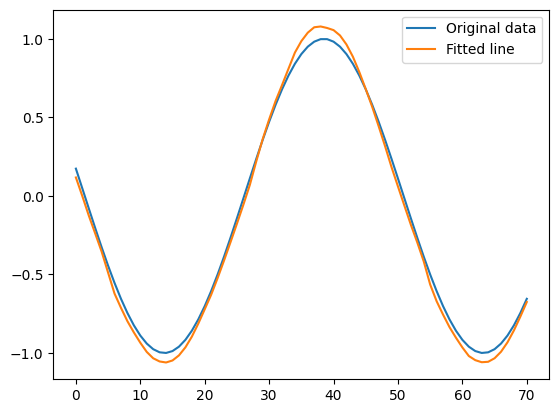

In [10]:
# plot original data and predictions
plt.plot(y_train, label='Original data')
plt.plot(model(x_train).detach(), label='Fitted line')
plt.legend()
plt.show()

In [8]:
# save model if better or not exists
model_weights = {'model_state_dict': model.state_dict(), 'val_loss': avg_val_loss}
weights_file = 'model_weights.pt'
if not os.path.isfile(weights_file):
    # save new
    torch.save(model_weights, weights_file)
elif model_weights['val_loss'] < torch.load(weights_file)['val_loss']:
    # replace
    torch.save(model_weights, weights_file)

In [9]:
# model loading
device = torch.device("cpu")
input_size = lookback
output_size = 1
model = MLP(input_size, output_size).to(device)
model.load_state_dict(torch.load('model_weights.pt')['model_state_dict'])
val_loss, avg_val_loss = evaluate(model, val_loader, criterion)
print(f'Validation Loss: {val_loss:.5f}, Average Validation Loss: {avg_val_loss:.5f}')

Validation Loss: 0.00265, Average Validation Loss: 0.00265
